# About
This notebook is an exploratory data analysis of the Walmart dataset used in the M5 forecasting competition.

## Dataset
The M5 competition is the latest of five recurring forecast competitions created by forecasting expert, Spyros Makridakis, as a way of measuring and comparing traditional statistacal forecasting methods vs new non-traditional methods such as ML.

From [the M5 website](https://mofc.unic.ac.cy/m5-competition/): 

<blockquote>The aim of the M5 Competition is similar to the previous four: that is to identify the most appropriate method(s) for different types of situations requiring predictions and making uncertainty estimates. Its ultimate purpose is to advance the theory of forecasting and improve its utilization by business and non-profit organizations. Its other goal is to compare the accuracy/uncertainty of ML and DL methods vis-à-vis those of standard statistical ones, and assess possible improvements versus the extra complexity and higher costs of using the various methods.</blockquote>

The dataset consists of five seperate 'csv' files which contain all of the data offered for the competition. In this particular competition, additional data is also allowed to be used.


# Imports
Notebook dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Setting up environment
Copying files into the Colab environment

In [2]:
!cp /content/drive/My\ Drive/m5/m5-forecasting-accuracy.zip /content/

In [3]:
!unzip /content/m5-forecasting-accuracy.zip

Archive:  /content/m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


# Library

## reduce_mem_usage

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# Full Dataset

In [5]:
full_df = pd.melt(reduce_mem_usage(pd.read_csv('sales_train_evaluation.csv')), id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
full_df = pd.merge(full_df, reduce_mem_usage(pd.read_csv('calendar.csv')), on='d', how='left')
full_df = pd.merge(full_df, reduce_mem_usage(pd.read_csv('sell_prices.csv')), on=['store_id','item_id','wm_yr_wk'], how='left') 

Mem. usage decreased to 96.13 Mb (78.8% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [6]:
full_df.set_index('date', inplace=True)

In [31]:
full_df.index = pd.to_datetime(full_df.index)

In [32]:
import gc
gc.collect()

374

In [33]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59181090 entries, 2011-01-29 to 2016-05-22
Data columns (total 21 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sold          int16  
 8   wm_yr_wk      int16  
 9   weekday       object 
 10  wday          int8   
 11  month         int8   
 12  year          int16  
 13  event_name_1  object 
 14  event_type_1  object 
 15  event_name_2  object 
 16  event_type_2  object 
 17  snap_CA       int8   
 18  snap_TX       int8   
 19  snap_WI       int8   
 20  sell_price    float16
dtypes: float16(1), int16(3), int8(5), object(12)
memory usage: 6.4+ GB


In [9]:
full_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


## Date Features
- *weekday*, *wday*, *month*, and *year* are all derived from the date
- *wm_yr_wk* is a unique id for the week
- *d* is the number of the day for each date in the dataset. Has corresponding column in the sales data that can be used as a key for join

In [10]:
date_features = ['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd']

full_df[date_features].head()

,wm_yr_wk,weekday,wday,month,year,d
date,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1
2011-01-29,11101,Saturday,1,1,2011,d_1
2011-01-29,11101,Saturday,1,1,2011,d_1
2011-01-29,11101,Saturday,1,1,2011,d_1
2011-01-29,11101,Saturday,1,1,2011,d_1


In [11]:
full_df[date_features].isna().sum()

wm_yr_wk    0
weekday     0
wday        0
month       0
year        0
d           0
dtype: int64

### date
- The dataset begins on January 29, 2011, and ends on June 19, 2016. This means there are 1,969 days included in the dataset.


In [12]:
print(f"Number of unique dates: {full_df.index.nunique()}")
print(f"Total number of entries: {full_df.shape[0]}")
print(f"Starting Date: {full_df.iloc[0].name}")
print(f"Ending Date: {full_df.iloc[-1].name}")

Number of unique dates: 1941
Total number of entries: 59181090
Starting Date: 2011-01-29
Ending Date: 2016-05-22


### wm_yr_wk
- Unique number for identifying which 'week' the datapoint belongs to
- No missing values

In [13]:
print(f"Number of unique values: {full_df['wm_yr_wk'].nunique()}")
print(f"Number of days in dataset divide by seven: {full_df['d'].nunique()/7}")
print(f"Missing: {full_df['wm_yr_wk'].isna().sum()}")

Number of unique values: 278
Number of days in dataset divide by seven: 277.2857142857143
Missing: 0


### weekday
- String indicating which day of the week it is, e.g. 'Sunday', 'Monday'

In [14]:
print(f"Days included: {full_df['weekday'].unique()}")

Days included: ['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday']


### wday
- Numerical version of the *weekday* feature
- We can see that the *wday* value of '1' corresponds to the *weekday* value of 'Saturday'

In [15]:
full_df[['weekday', 'wday']].sample(7)

,weekday,wday
date,,
2013-07-21,Sunday,2
2011-10-28,Friday,7
2015-04-06,Monday,3
2015-02-16,Monday,3
2013-12-20,Friday,7
2015-12-23,Wednesday,5
2013-08-23,Friday,7


### month
- The number of the month, with January being represented by '1'

In [16]:
full_df[['month']].sample(5)

,month
date,
2015-12-27,12
2015-02-05,2
2011-11-17,11
2014-09-26,9
2012-05-17,5


### year
- 2012 is a leap year, as there are 366 days

In [17]:
print(f"Years represented: {full_df['year'].unique()}")

Years represented: [2011 2012 2013 2014 2015 2016]


In [18]:
for year in full_df['year'].unique():
    print(f"{full_df[full_df['year'] == year]['d'].nunique()} days in the year {year}")

337 days in the year 2011
366 days in the year 2012
365 days in the year 2013
365 days in the year 2014
365 days in the year 2015
143 days in the year 2016


### d
- Key for indexing dataset by number, 1-1969


In [19]:
print(f"Contains values from {full_df['d'].values[0]} to {full_df['d'].values[-1]}")
print(f"{full_df['d'].nunique()} unique values")

Contains values from d_1 to d_1941
1941 unique values


## Event Features
The event features contain indicators for whether or not a special event occurred on the given day.

There are two different event columns, for the rare occurrence that two events fall on the same day.

- *event_name_* and *event_type_* represent whether or not a special event occurred on that day


In [20]:
full_df[['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].isna().sum()

event_name_1    54363670
event_type_1    54363670
event_name_2    59059130
event_type_2    59059130
dtype: int64

### event_name_1
- The first year is missing all the January events, while the last year is missing all the events after June 19 because that is when the data is cutoff
- Missing events are in the event_name_2

In [21]:
all_event_names = full_df['event_name_1'].unique()
print(f"{full_df['event_name_1'].isna().sum()} Nan values")
print(f"Unique Values ({full_df['event_name_1'].nunique()}): {all_event_names}")

54363670 Nan values
Unique Values (30): [nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']


In [22]:
for year in full_df['year'].unique():
    events = full_df[full_df['year'] == year]['event_name_1']
    print(f"{'*'*10}-{year}-{'*'*10}")
    print(f"Number of holidays represented: {events.nunique()}")
    print(f"Events missing:\n{[name for name in all_event_names if name not in events.unique() ]}\n")

**********-2011-**********
Number of holidays represented: 26
Events missing:
[nan, 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter']

**********-2012-**********
Number of holidays represented: 30
Events missing:
[nan]

**********-2013-**********
Number of holidays represented: 29
Events missing:
[nan, 'Cinco De Mayo']

**********-2014-**********
Number of holidays represented: 28
Events missing:
[nan, 'OrthodoxEaster', "Father's day"]

**********-2015-**********
Number of holidays represented: 30
Events missing:
[nan]

**********-2016-**********
Number of holidays represented: 15
Events missing:
[nan, 'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day", 'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End']



### event_type_1
- Type of event if any on the specific day

In [23]:
print(f"{full_df['event_type_1'].isna().sum()} Nan values")
print(f"Unique Values ({full_df['event_type_1'].nunique()}): {full_df['event_type_1'].unique()}")
full_df.dropna()[['event_name_1', 'event_type_1']]

54363670 Nan values
Unique Values (4): [nan 'Sporting' 'Cultural' 'National' 'Religious']


,event_name_1,event_type_1
date,,
2011-04-24,OrthodoxEaster,Religious
2011-04-24,OrthodoxEaster,Religious
2011-04-24,OrthodoxEaster,Religious
2011-04-24,OrthodoxEaster,Religious
2011-04-24,OrthodoxEaster,Religious
...,...,...
2014-06-15,NBAFinalsEnd,Sporting
2014-06-15,NBAFinalsEnd,Sporting
2014-06-15,NBAFinalsEnd,Sporting


In [34]:
full_df.index

DatetimeIndex(['2011-01-29', '2011-01-29', '2011-01-29', '2011-01-29',
               '2011-01-29', '2011-01-29', '2011-01-29', '2011-01-29',
               '2011-01-29', '2011-01-29',
               ...
               '2016-05-22', '2016-05-22', '2016-05-22', '2016-05-22',
               '2016-05-22', '2016-05-22', '2016-05-22', '2016-05-22',
               '2016-05-22', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=59181090, freq=None)

In [37]:
full_df['2014'].groupby(['year', 'month', 'event_type_1', 'event_name_1'])[['d']].count()

d
year month event_type_1 event_name_1              
2014 1     National     MartinLutherKingDay  30490
                        NewYear              30490
           Religious    OrthodoxChristmas    30490
     2     Cultural     ValentinesDay        30490
           National     PresidentsDay        30490
           Sporting     SuperBowl            30490
     3     Cultural     StPatricksDay        30490
           Religious    LentStart            30490
                        LentWeek2            30490
                        Purim End            30490
     4     Cultural     Easter               30490
           Religious    Pesach End           30490
     5     Cultural     Cinco De Mayo        30490
                        Mother's day         30490
           National     MemorialDay          30490
     6     Religious    Ramadan starts       30490
           Sporting     NBAFinalsEnd         30490
                        NBAFinalsStart       30490
     7     National     IndependenceDay      30490
           Religious    Eid al-Fitr          30490
     9     National     LaborDay             30490
     10    Cultural     Halloween            30490
           National     ColumbusDay          30490
           Religious    EidAlAdha            30490
     11    National     Thanksgiving         30490
                        VeteransDay          30490
     12    National     Christmas            30490
           Religious    Chanukah End         30490

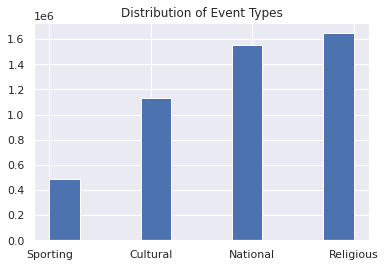

In [40]:
full_df['event_type_1'].hist()
plt.title('Distribution of Event Types');

### event_name_2
- Contains the events name if a given day already contains an event_name_1


In [46]:
for year in full_df['year'].unique():
    events = full_df[full_df['year'] == year]['event_name_2']
    print(f"{'*'*10}-{year}-{'*'*10}")
    print(f"Number of holidays represented: {events.nunique()}")
    print(f"Events:\n{[name for name in all_event_names if name in events.unique() ]}\n")

**********-2011-**********
Number of holidays represented: 1
Events:
['Easter']

**********-2012-**********
Number of holidays represented: 0
Events:
[]

**********-2013-**********
Number of holidays represented: 1
Events:
['Cinco De Mayo']

**********-2014-**********
Number of holidays represented: 2
Events:
['OrthodoxEaster', "Father's day"]

**********-2015-**********
Number of holidays represented: 0
Events:
[]

**********-2016-**********
Number of holidays represented: 0
Events:
[]



### event_type_2


In [47]:
print(f"{full_df['event_type_1'].isna().sum()} Nan values")
print(f"Unique Values ({full_df['event_type_2'].nunique()}): {full_df['event_type_2'].unique()}")
full_df.dropna()[['event_name_2', 'event_type_2']]

54363670 Nan values
Unique Values (2): [nan 'Cultural' 'Religious']


,event_name_2,event_type_2
date,,
2011-04-24,Easter,Cultural
2011-04-24,Easter,Cultural
2011-04-24,Easter,Cultural
2011-04-24,Easter,Cultural
2011-04-24,Easter,Cultural
...,...,...
2014-06-15,Father's day,Cultural
2014-06-15,Father's day,Cultural
2014-06-15,Father's day,Cultural


## Snap Features
One column for each state, indicates whether or not SNAP is allowed for the date.

Each state accepts SNAP that same amount of days per year.

- *snap_* indicates whether or not SNAP is being disbursed on that day in that state


In [48]:
full_df[['snap_CA', 'snap_TX', 'snap_WI']].isna().sum()

snap_CA    0
snap_TX    0
snap_WI    0
dtype: int64

### snap_CA

In [54]:
full_df['revenue'] = full_df['sell_price'] * full_df['sold']

In [55]:
full_df[full_df['state_id'] == 'CA'].groupby('snap_CA').mean()[['revenue']]

,revenue
snap_CA,
0,4.519709
1,4.861326


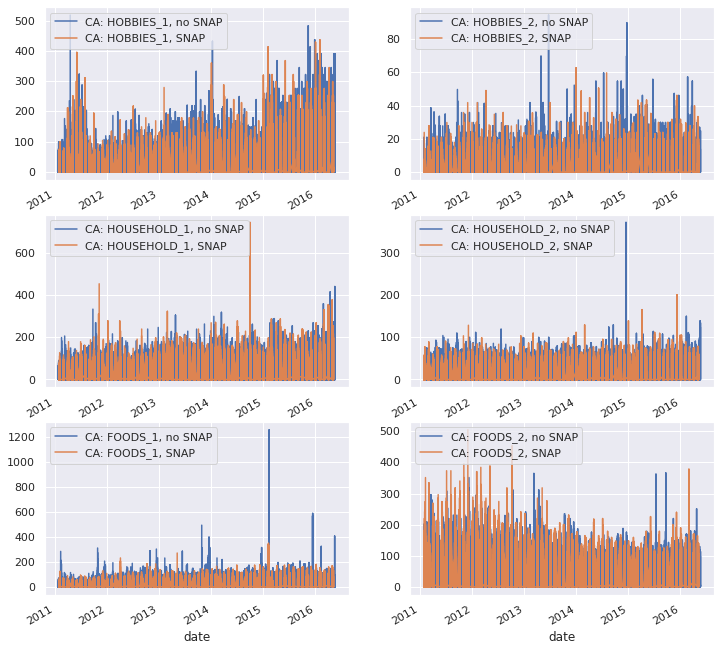

In [72]:
state_id = 'CA'
fig, ax = plt.subplots(full_df['dept_id'].nunique()//2, 2, figsize=(12, 12))
for ax, dept_id in zip(ax.flatten(), full_df['dept_id'].unique()):
    full_df[(full_df['state_id'] == state_id) &
            (full_df['dept_id'] == dept_id) &
            (full_df[f'snap_{state_id}'] == 0)]['revenue'].plot(ax=ax, label=f"{state_id}: {dept_id}, no SNAP")
    full_df[(full_df['state_id'] == state_id) &
            (full_df['dept_id'] == dept_id) & 
            (full_df[f'snap_{state_id}'] == 1)]['revenue'].plot(ax=ax, label=f"{state_id}: {dept_id}, SNAP")
    ax.legend(loc='upper left')


### snap_TX


In [56]:
full_df[full_df['state_id'] == 'TX'].groupby('snap_TX').mean()[['revenue']]

,revenue
snap_TX,
0,3.708030
1,4.118168


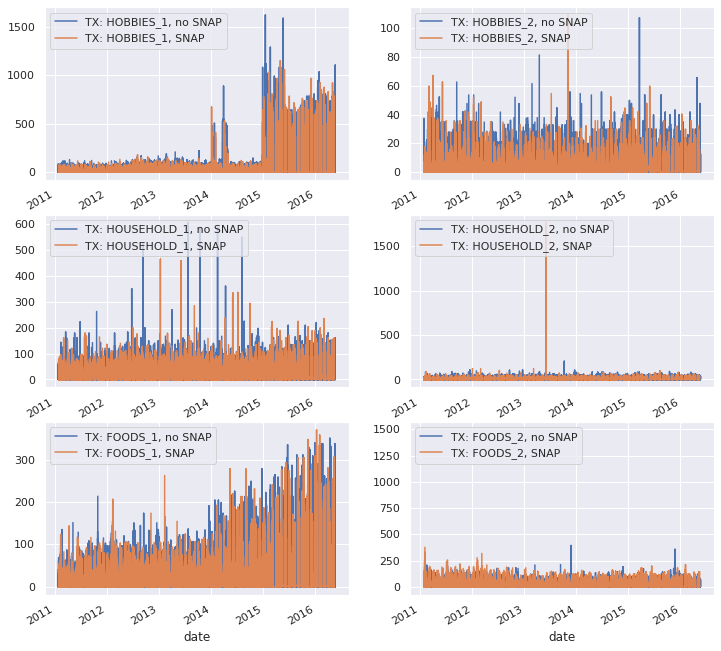

In [74]:
state_id = 'TX'
fig, ax = plt.subplots(full_df['dept_id'].nunique()//2, 2, figsize=(12, 12))
for ax, dept_id in zip(ax.flatten(), full_df['dept_id'].unique()):
    full_df[(full_df['state_id'] == state_id) &
            (full_df['dept_id'] == dept_id) &
            (full_df[f'snap_{state_id}'] == 0)]['revenue'].plot(ax=ax, label=f"{state_id}: {dept_id}, no SNAP")
    full_df[(full_df['state_id'] == state_id) &
            (full_df['dept_id'] == dept_id) & 
            (full_df[f'snap_{state_id}'] == 1)]['revenue'].plot(ax=ax, label=f"{state_id}: {dept_id}, SNAP")
    ax.legend(loc='upper left')

### snap_WI

In [57]:
full_df[full_df['state_id'] == 'WI'].groupby('snap_WI').mean()[['revenue']]

,revenue
snap_WI,
0,3.380226
1,4.083328


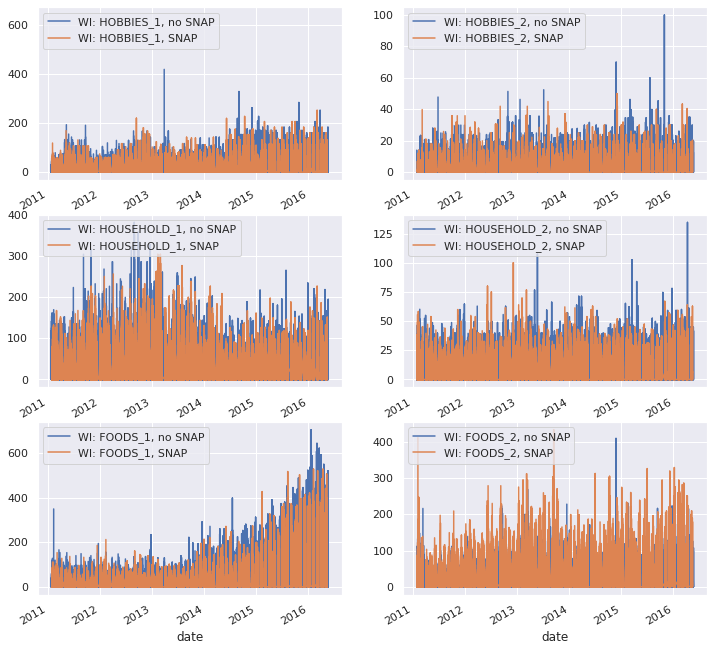

In [75]:
state_id = 'WI'
fig, ax = plt.subplots(full_df['dept_id'].nunique()//2, 2, figsize=(12, 12))
for ax, dept_id in zip(ax.flatten(), full_df['dept_id'].unique()):
    full_df[(full_df['state_id'] == state_id) &
            (full_df['dept_id'] == dept_id) &
            (full_df[f'snap_{state_id}'] == 0)]['revenue'].plot(ax=ax, label=f"{state_id}: {dept_id}, no SNAP")
    full_df[(full_df['state_id'] == state_id) &
            (full_df['dept_id'] == dept_id) & 
            (full_df[f'snap_{state_id}'] == 1)]['revenue'].plot(ax=ax, label=f"{state_id}: {dept_id}, SNAP")
    ax.legend(loc='upper left')

## Hierarchical Id Features
The items to be predicted are presented in a hierchical format.

From top to bottom:

### state_id

In [31]:
print(f"Number of Unique: {full_df['state_id'].nunique()}")
print(f"Unique Values:\n{full_df['state_id'].unique()}")

Number of Unique: 3
Unique Values:
['CA' 'TX' 'WI']


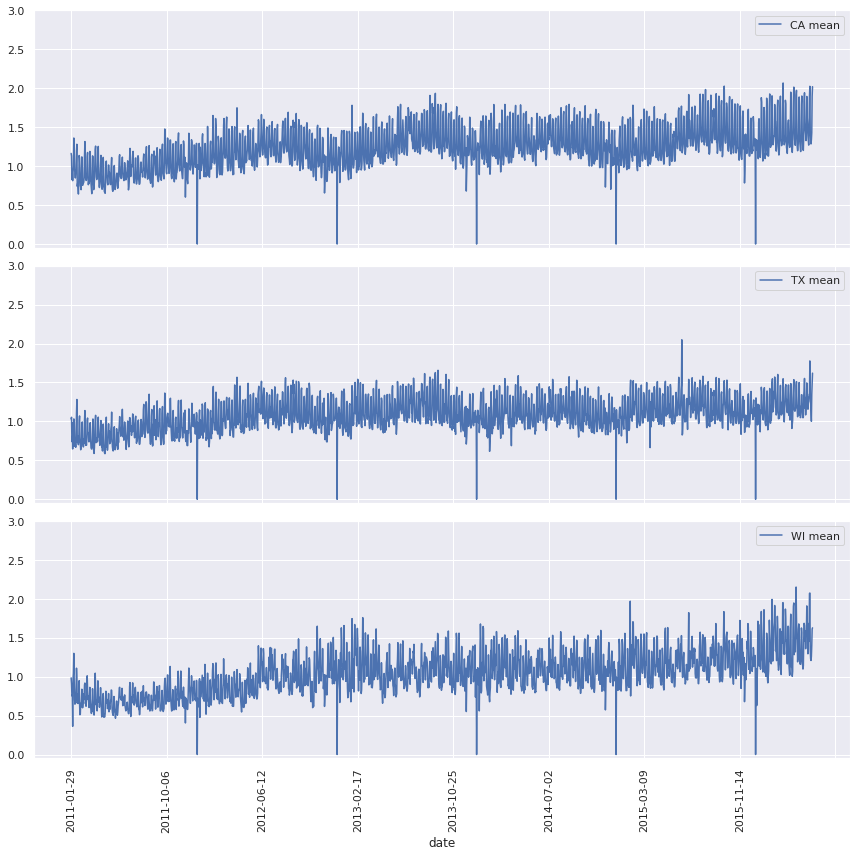

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True, sharey=True)
for state_id, ax in zip(full_df['state_id'].unique(), ax.flatten()):
    full_df[full_df['state_id'] == state_id].groupby('date')['sold'].mean().plot(ax=ax, rot=90, label=f"{state_id} mean")
    ax.legend()
    ax.set_ylim(-.05, 3)
plt.tight_layout();

### store_id
Breaks the dataset into ten different store Id's.

Four in CA, and three in both TX and WI.

In [61]:
print(f"Number of Unique: {full_df['store_id'].nunique()}")
print(f"Unique Values:\n{full_df['store_id'].unique()}")

Number of Unique: 10
Unique Values:
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


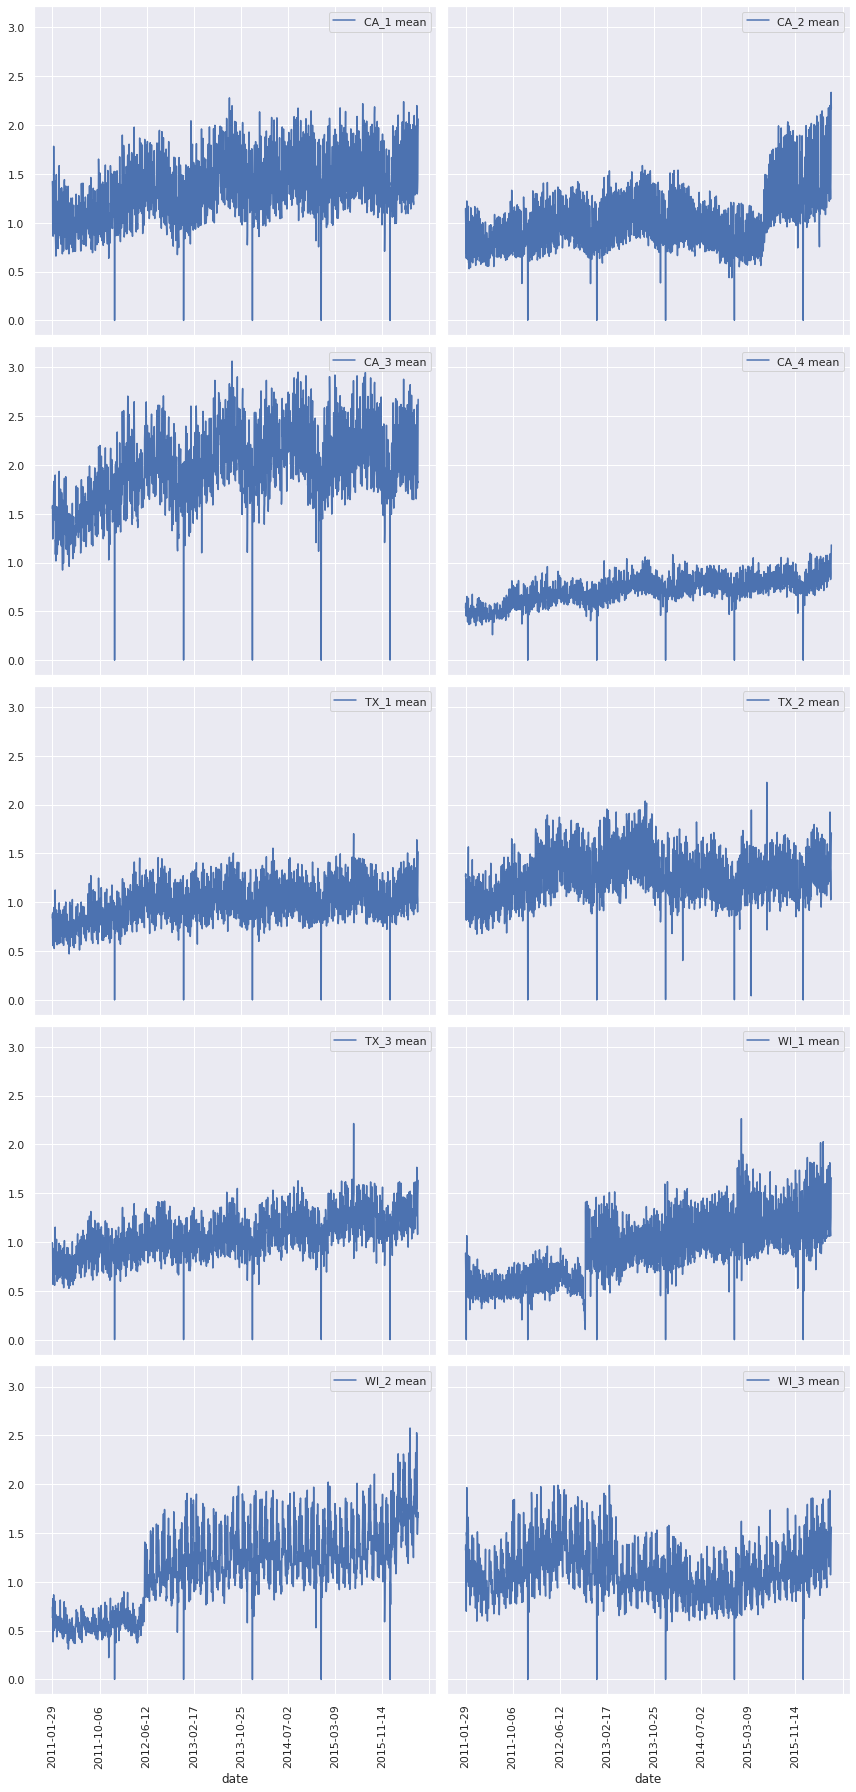

In [85]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12), sharex=True, sharey=True)
for store_id, ax in zip(full_df['store_id'].unique(), ax.flatten()):
    full_df[full_df['store_id'] == store_id].groupby('date')['sold'].mean().plot(ax=ax, rot=90, label=f"{store_id} mean")
    # ax.set_title(f'Store {store_id}, Mean Sales')
    ax.legend()
plt.tight_layout();

### cat_id

In [69]:
print(f"Number of Unique: {full_df['cat_id'].nunique()}")
print(f"Unique Values:\n{full_df['cat_id'].unique()}")

Number of Unique: 3
Unique Values:
['HOBBIES' 'HOUSEHOLD' 'FOODS']


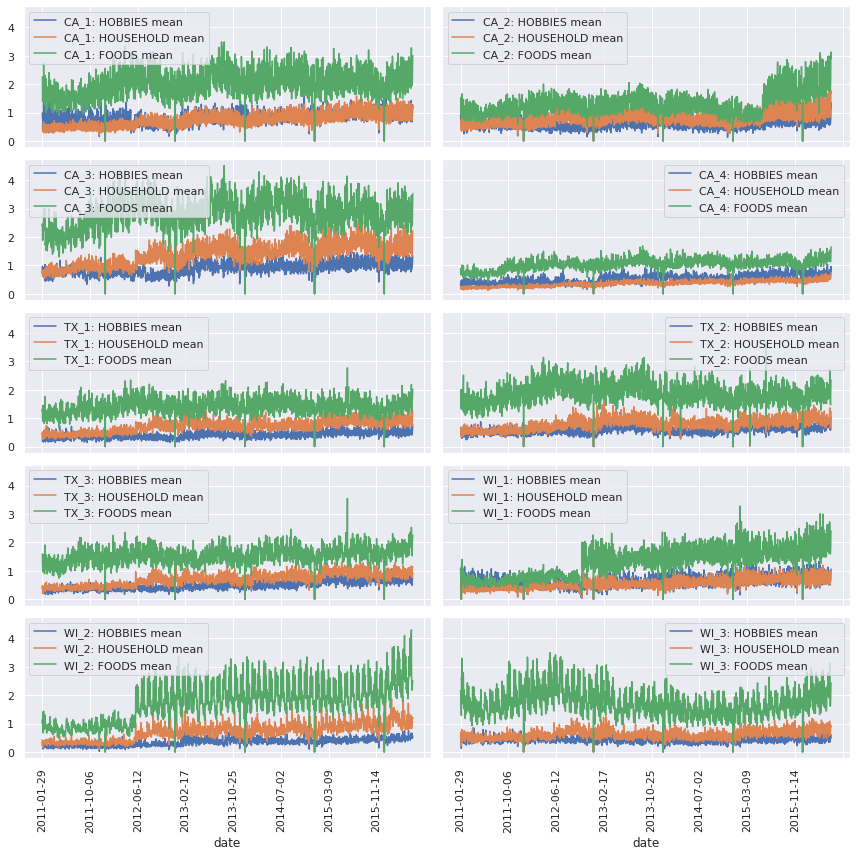

In [82]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12), sharex=True, sharey=True)
for ax, store_id in zip(ax.flatten(), full_df['store_id'].unique()):
    for cat_id in full_df['cat_id'].unique():
        full_df[(full_df['cat_id'] == cat_id) & 
                (full_df['store_id'] == store_id)].groupby('date')['sold'].mean().plot(ax=ax, rot=90, label=f"{store_id}: {cat_id} mean")    
    ax.legend()
plt.tight_layout();

### dept_id

In [76]:
print(f"Number of Unique: {full_df['dept_id'].nunique()}")
print(f"Unique Values:\n{full_df['dept_id'].unique()}")

Number of Unique: 7
Unique Values:
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']


### item_id
Represents the individual items id.

3,049 different unique items.

In [77]:
print(f"Unique values: {full_df['item_id'].nunique()}")
full_df.sample(5)['item_id']

Unique values: 3049


date
2011-12-04    HOUSEHOLD_1_411
2015-04-19        FOODS_3_193
2014-07-21        FOODS_3_437
2013-04-22    HOUSEHOLD_1_324
2011-09-04      HOBBIES_1_181
Name: item_id, dtype: object

### id
Unique identifier, created with item_id, store_id, and '_evaluation'.

In [78]:
print(f"Unique: {full_df['id'].nunique()}")
full_df.head()[['id', 'item_id', 'store_id']]

Unique: 30490


,id,item_id,store_id
date,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,CA_1
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,CA_1
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,CA_1
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,CA_1
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,CA_1


## Price Feature
Consists of *sell_price*, which is an indicator of the sell price of that item on that day. 

Can fluctuate and vary depending on time and which store it comes from.

In [79]:
full_df[['sell_price']].isna().sum()

sell_price    12299413
dtype: int64

### sell_price

In [80]:
full_df.item_id.nunique()

3049

In [81]:
full_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
date,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2011-01-29,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2011-01-29,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2011-01-29,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2011-01-29,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-22,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,11617,Sunday,2,5,2016,NaN,NaN,NaN,NaN,0,0,0,2.980469,2.980469
2016-05-22,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,11617,Sunday,2,5,2016,NaN,NaN,NaN,NaN,0,0,0,2.480469,0.000000
2016-05-22,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,11617,Sunday,2,5,2016,NaN,NaN,NaN,NaN,0,0,0,3.980469,7.960938


In [83]:
full_df['sell_price']

date
2011-01-29         NaN
2011-01-29         NaN
2011-01-29         NaN
2011-01-29         NaN
2011-01-29         NaN
                ...   
2016-05-22    2.980469
2016-05-22    2.480469
2016-05-22    3.980469
2016-05-22    1.280273
2016-05-22    1.000000
Name: sell_price, Length: 59181090, dtype: float16

# sample_submission.csv
Example of the expected submission format.

It is expected to submit 28 day predictions for both the validation set as well as the evaluation set.

However, since the validation set has been released, it contains the actual values for the evaluation predictions.

This means the first half an be filled in with the actual demand, while the second half will be filled in with the final 28 day predictions.

In [84]:
sample_submission_df = reduce_mem_usage(pd.read_csv('sample_submission.csv'))

Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [85]:
sample_submission_df.shape

(60980, 29)

In [86]:
sample_submission_df.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
